In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve, generate_binary_structure
from tqdm import tqdm

# Modelo de Ising

Considere el modelo de Ising en dos dimensiones en red cuadrada, con hamiltoniano 

\begin{equation}
    H = -J \sum_{\left \langle i,j \right \rangle} s_i s_j
    \label{1}
\end{equation} 

donde $s_i$ es el espin de una sola partícula en la red (ya sea -1 o 1) y la suma de $<i,j>$ significa sumar los vecinos más cercanos para todos los puntos en la red. $\mu$ corresponde a una configuración particular de los giros.


Se crean dos redes random. Una será la inversa de la otra para ver cómo evolucionan.

In [2]:
#Dimensión de la red
N=10
#Crea una red de espines al azar, esta red suele estar neutra(la mitad de espines hacia arriba y la otra hacia abajo)
def red_espines(N, M):
    return np.random.choice([-1, 1], size=(N, M))
#Red de espines
red_n=red_espines(N,N)
#Red de espines inversa
red_p=red_n*-1

Muestra de nuestra red de espines

Cantidad de spines: 100


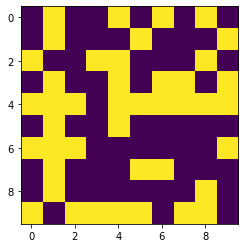

In [3]:
plt.imshow(red_n)
print("Cantidad de spines:", N**2)

Función para obtener la energía adimensional $E/J = -\frac{1}{2}\sum_{<i,j>} s_i s_j$ teniendo en cuenta condiciones de borde periodicas

In [4]:
def E_a(red):
    # Aplica suma de vecinos más cercanos con periodicidad
    kern = generate_binary_structure(2, 1) 
    kern[1][1] = False
    #Se divide entre dos ya que se suma dos veces
    arr = -0.5*red*convolve(red, kern, mode='wrap', cval=0)
    return arr.sum()

In [5]:
E_a(red_n)

12.0

# Algoritmo de Metropolis

El algoritmo de Metropolis se basa en generar configuraciones aleatorias del sistema con peso estadístico $e^{-\beta H}$ y usar estas para calcular promedios de las cantidades físicas de interés.
El algoritmo es el siguiente: 
1. Se genera una configuración de espines al azar.
2. Se selecciona un espín de la red al azar. 
3. Se calcula el cambio de la energía total del sistema $\Delta E$ si este espín se voltea. 
4. Si $\Delta E \leq 0$ se acepta el cambio y se repite el proceso a partir de 2. 
5. Si $\Delta E > 0$, se escoge un número real aleatorio p entre [0, 1] con probabilidad uniforme y si $ p < e^{-\beta \Delta E} $ se acepta el cambio del espín, de lo contrario no se acepta y se regresa el espín a su configuración anterior. 
6. Se repite el proceso a partir de 2. 

In [6]:
def metropolis(red_espin, times, BJ):
    sum_espins=np.zeros(times) #Suma de los espines
    energias = np.zeros(times) #Array de energias
    red= red_espin.copy() #Matriz de espines que sera cambiada
    #Montecarlo
    for t in range(times):
        #Energia inicial
        E_i=E_a(red)
        # Escoge un espin random
        x = np.random.randint(0,N)
        y = np.random.randint(0,N)
        spin_i = red[x,y] #Espin inicial
        spin_f = spin_i*-1 #Espin volteado
        red[x,y]=spin_f # Cambio en el espin 
        #Energia final
        E_f = E_a(red)
        #Diferencia de energia
        dE = E_f-E_i
        # Cambio de estado
        if dE<=0:
            sum_espins[t] = red.sum()
            energias[t] = E_f
        elif (dE>0)*(np.random.uniform(0, 1) < np.exp(-BJ*dE)):
            sum_espins[t] = red.sum()
            energias[t] = E_f
        else:
            red[x,y]=spin_i # El espin vuelve a ser como antes
            sum_espins[t] = red.sum()
            energias[t] = E_i
    return sum_espins, energias

Nos da el arreglo de espines y energía a través de las interaciones. Teniendo en consideración que $JB_{critico}=0.8814$

In [7]:
BJc=0.8814
BJ=1

In [8]:
spins, energias = metropolis(red_n, 50000, BJ)

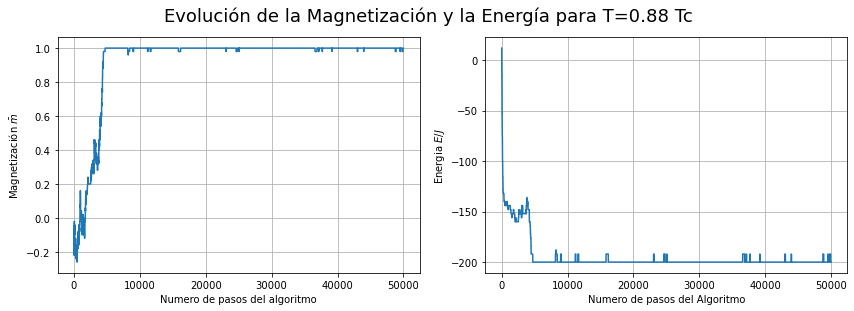

In [9]:
T_Tc=BJc/BJ
fig, axes = plt.subplots(1, 2, figsize=(12,4))
ax = axes[0]
ax.plot(spins/N**2)
ax.set_xlabel('Numero de pasos del algoritmo')
ax.set_ylabel(r'Magnetización $\bar{m}$')
ax.grid()
ax = axes[1]
ax.plot(energias)
ax.set_xlabel('Numero de pasos del Algoritmo')
ax.set_ylabel(r'Energia $E/J$')
ax.grid()
fig.tight_layout()
fig.suptitle(f'Evolución de la Magnetización y la Energía para T={T_Tc:.2f} Tc', y=1.07, size=18)
plt.show()

Aquí obtengo $\bar{m}$ y $E/J$ para diferentes valores de $\beta J$. Se toman en cuenta solamente el promedio de los últimos 10 mil datos.


In [10]:
def cambio_BJ(red, BJs):
    ms = np.zeros(len(BJs))
    E_means = np.zeros(len(BJs))
    #Da estimado de cuanto demora el código
    for i in tqdm(range(len(BJs))):
        spins, energies = metropolis(red, 50000, BJs[i])
        ms[i] = spins[-10000:].mean()/N**2
        E_means[i] = energies[-10000:].mean()
    return ms, E_means
b=np.linspace(0.3,2,20)
a=np.linspace(0.25,0.60,25)
BJs=np.concatenate((a,b))
print(BJs)
ms_n, E_means_n= cambio_BJ(red_n, BJs)
ms_p, E_means_p= cambio_BJ(red_p, BJs)

[0.25       0.26458333 0.27916667 0.29375    0.30833333 0.32291667
 0.3375     0.35208333 0.36666667 0.38125    0.39583333 0.41041667
 0.425      0.43958333 0.45416667 0.46875    0.48333333 0.49791667
 0.5125     0.52708333 0.54166667 0.55625    0.57083333 0.58541667
 0.6        0.3        0.38947368 0.47894737 0.56842105 0.65789474
 0.74736842 0.83684211 0.92631579 1.01578947 1.10526316 1.19473684
 1.28421053 1.37368421 1.46315789 1.55263158 1.64210526 1.73157895
 1.82105263 1.91052632 2.        ]


100%|██████████| 45/45 [05:34<00:00,  7.44s/it]


Mirando  $\bar{m}$ como una función de la temperatura sobre la temperatura critica $T/T_c = JB_c / JB $

[3.5256     3.33127559 3.15725373 3.00051064 2.85859459 2.72949677
 2.61155556 2.50338462 2.40381818 2.31186885 2.22669474 2.1475736
 2.07388235 2.00508057 1.94069725 1.88032    1.82358621 1.77017573
 1.71980488 1.67222134 1.6272     1.58453933 1.54405839 1.50559431
 1.469      2.938      2.26305405 1.84028571 1.55061111 1.339728
 1.17933803 1.05324528 0.95151136 0.86769948 0.79745714 0.73773568
 0.68633607 0.64163218 0.60239568 0.56768136 0.53675    0.5090152
 0.48400578 0.46133884 0.4407    ]


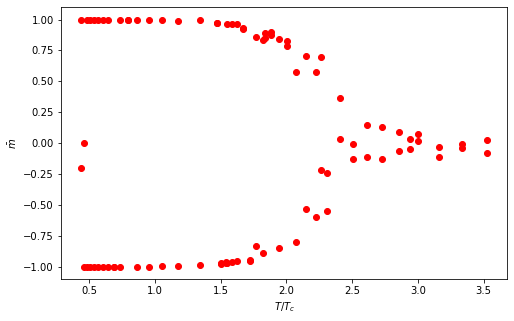

In [11]:
print(BJc/BJs)
plt.figure(figsize=(8,5))
plt.scatter(BJc/BJs, ms_n,color="r")
plt.scatter(BJc/BJs, ms_p,color="r")
plt.xlabel(r'$T/T_{c}$')
plt.ylabel(r'$\bar{m}$')
plt.show()

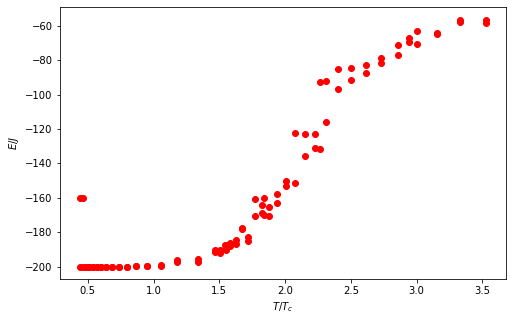

In [12]:
plt.figure(figsize=(8,5))
plt.scatter(BJc/BJs, E_means_n,color="r")
plt.scatter(BJc/BJs, E_means_p,color="r")
plt.xlabel(r'$T/T_{c}$')
plt.ylabel(r'$E/J$')
plt.show()

# Pruebas para realizar la suma de los vecinos más cercanos.

A continuación unas partes preliminares que realicé para lograr hacer el código correctamente.

In [13]:
#Pruebas para conseguir realizar una convolución que de una matriz "b" que sea la suma sobre los vecinos más cercanos 
#Generamos una red al azar a
a=red_espines(5, 5)
#Kernel que da la condición de suma sobre los vecinos cercanos.
k = generate_binary_structure(2, 1) 
k[1][1] = False
print(k,"Kernel usado")
#Matriz b donde cada posición corresponde a la suma de los vecinos más cercanos en la posición correspondiente con periocidad
#mode='wrap' es lo que permite considerar la periodicidad de la red.
b=convolve(a, k, mode='wrap', cval=0.0)
print(a, "Red de espines")
print(b, "Suma de los vecinos")
#plt.imshow(random_spin_field(10, 10))

[[False  True False]
 [ True False  True]
 [False  True False]] Kernel usado
[[ 1 -1  1 -1 -1]
 [-1 -1  1 -1  1]
 [ 1  1  1 -1 -1]
 [ 1  1 -1  1 -1]
 [-1  1  1  1  1]] Red de espines
[[-4  2  0  0  2]
 [ 2  0  0  0 -4]
 [ 0  2  0  0  0]
 [ 0  2  4 -2  2]
 [ 4  0  2  2 -2]] Suma de los vecinos
